In [1]:
#Import libraries
import tensorflow as tf
import numpy as np
import math

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
0


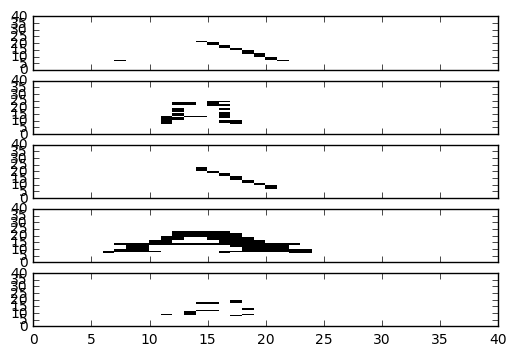

In [2]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

np.random.seed(0)

#Load data
data = np.load('data_with_labels.npz')
train = data['arr_0']/255
labels = data['arr_1']

#look at some data
print(train[0])
print(labels[0])

import matplotlib.pyplot as plt
plt.ion()

#Lets, look at a subplot of one of A in each font
plt.figure(figsize = (10,10))
f, plts = plt.subplots(5, sharex=True)
c = 91
for i in range(5):
    plts[i].pcolor(train[c + i *558], cmap = plt.cm.gray_r)

In [3]:
def to_onehot(labels, nclasses = 5):
    '''
    Convert labels to "one hot" format
    '''
    outputlabels = np.zeros((len(labels), nclasses))
    for i, l in enumerate(labels):
        outputlabels[i, l] = 1
    return outputlabels

onehot = to_onehot(labels)

In [5]:
# Split data into training and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt], indices[valid_cnt:]
test, train = train[test_idx,:], train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:], onehot[training_idx,:]

sess = tf.InteractiveSession()


# These will be inputs
## Input pixels, flattened
x = tf.placeholder("float", [None, 1296])
## Known labels
y_ = tf.placeholder("float", [None,5])

# Hidden layer
num_hidden_1 = 128
W1 = tf.Variable(tf.truncated_normal([1296, num_hidden_1],
                                        stddev=1./math.sqrt(1296)))
b1 = tf.Variable(tf.constant(0.1,shape=[num_hidden_1]))
h1 = tf.sigmoid(tf.matmul(x, W1) + b1)

# Second hidden layer
num_hidden_2 = 32
W2 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2],
                                        stddev=2./math.sqrt(num_hidden_1)))
b2 = tf.Variable(tf.constant(0.2,shape=[num_hidden_2]))

h2 = tf.sigmoid(tf.matmul(h1, W2) + b2)

W3 = tf.Variable(tf.truncated_normal([num_hidden_2, 5],
                                        stddev=1./math.sqrt(5)))
b3 = tf.Variable(tf.constant(0.1,shape=[5]))


# Just initialize
sess.run(tf.initialize_all_variables())

# Define model
y = tf.nn.softmax(tf.matmul(h2,W3) + b3)

### End model specification, begin training code


# Climb on cross-entropy
cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(y + 1e-50, y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# Actually train
epochs = 25000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs), ascii=True):
    if i % 10 == 0:  # Record summary data, and the accuracy
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x: train.reshape([-1,1296]), y_: onehot_train})
        train_acc[i//10] = A

        # And now the validation set
        A = accuracy.eval(feed_dict={x: test.reshape([-1,1296]), y_: onehot_test})
        test_acc[i//10] = A
    train_step.run(feed_dict={x: train.reshape([-1,1296]), y_: onehot_train})

100%|##########| 25000/25000 [1:18:00<00:00,  5.34it/s]   1/25000 [00:00<1:48:20,  3.85it/s] 27%|##7       | 6837/25000 [49:44<2:12:08,  2.29it/s]


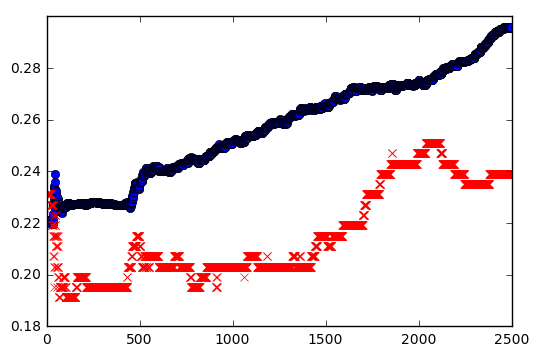

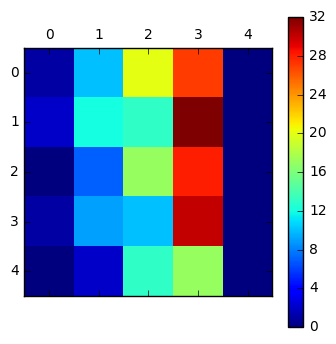

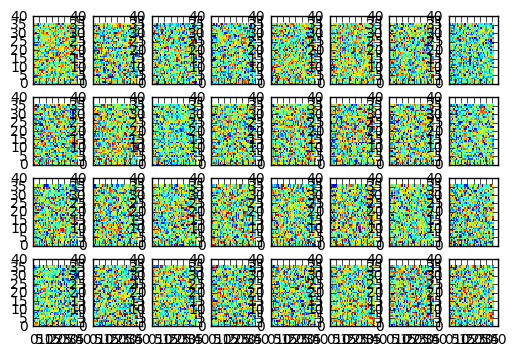

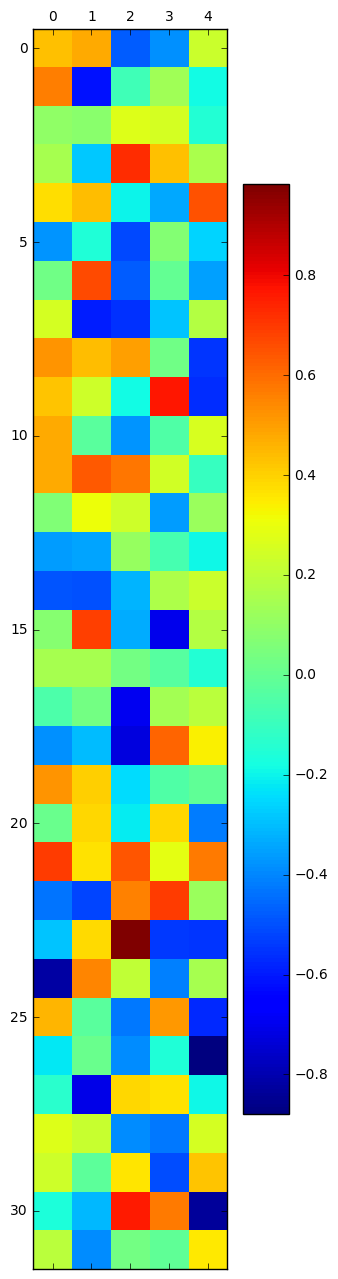

In [6]:
# Plot the accuracy curves
plt.plot(train_acc,'bo')
plt.plot(test_acc,'rx')

# Look at the final testing confusion matrix
pred = np.argmax(y.eval(feed_dict={x: test.reshape([-1,1296]), y_: onehot_test}), axis = 1)
conf = np.zeros([5,5])
for p,t in zip(pred,np.argmax(onehot_test,axis=1)):
    conf[t,p] += 1

plt.matshow(conf)
plt.colorbar()

# Let's look at a subplot of some weights
f, plts = plt.subplots(4,8, sharex=True)
for i in range(32):
    plts[i//8, i%8].pcolormesh(W1.eval()[:,i].reshape([36,36]))

    
#Examine the output weights

plt.matshow(W3.eval())
plt.colorbar()

#Save weight
saver = tf.train.Saver()
saver.save(sess, "mlp.ckpt")

#Restore
saver.restore(sess, "mlp.ckpt")